In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Definicja funkcji relaksacji

In [2]:
def relaxation_method(nx, ny, delta, v_left, v_top, v_bottom, epsilon, rho_max, sigma_rho, tol=1e-6, it_max=int(1e4), omega=1.8):
    xmax = delta * nx
    ymax = delta * ny
    
    V = np.zeros((ny+1, nx+1))
    rho = np.zeros((ny+1, ny+1))

    for j in range(0, ny+1):
        for i in range(0, nx+1):
            x = i * delta
            y = j * delta
            rho[i, j] = rho_max * np.exp(-((x - delta * nx / 2) ** 2 + (y - delta * ny / 2) ** 2) / (2 * sigma_rho ** 2))

    for j in range(0, ny+1):
        for i in range(0, nx+1):
            x = i * delta
            y = j * delta
            V[0, j] = v_left * np.sin(np.pi * y / ymax)
            V[i, 0] = v_bottom * np.sin(np.pi * x / xmax)
            V[i, ny] = v_top * np.sin(np.pi * x / xmax)

    F_old = 0
    F_new = 0

    for it in range(1, it_max):
        for j in range(1, ny):
            for i in range(1, nx):
                V[i, j] = (1 - omega) * V[i, j] + omega / 4 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1] + delta**2 / epsilon * rho[i, j])
        
        for j in range(1, ny):
            V[nx, j] = V[nx-1, j]

        F_old = F_new
        F_new = 0
        for j in range(1, ny):
            for i in range(1, nx):
                E_x = (V[i+1, j] - V[i-1, j]) / (2 * delta)
                E_y = (V[i, j+1] - V[i, j-1]) / (2 * delta)
                F_new += (E_x ** 2 + E_y ** 2) / 2 - rho[i, j] * V[i, j]

        if abs((F_new - F_old) / F_new) < tol:
            break

    return V

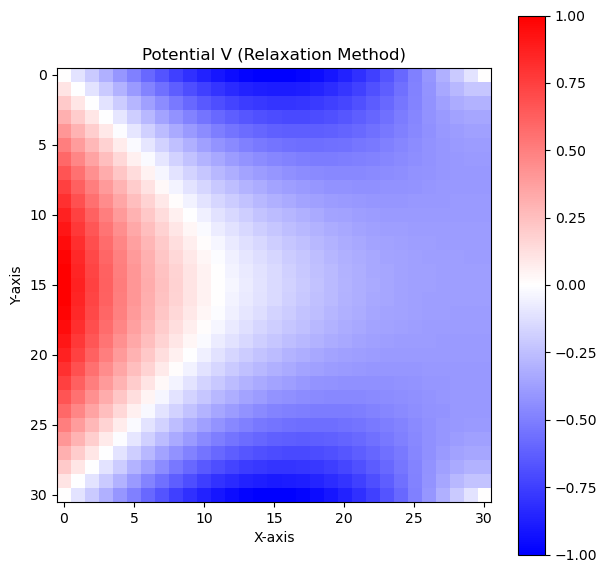

In [6]:
nx = ny = 30
delta = 0.1
v_left = 1
v_top = v_bottom = -1
epsilon = 1
rho_max = 1
sigma_rho = (delta * nx) / 10

V_relaxed = relaxation_method(nx, ny, delta, v_left, v_top, v_bottom, epsilon, rho_max, sigma_rho)
plt.figure(figsize = (7,7))
plt.imshow(V_relaxed.T, cmap='bwr')
plt.colorbar()
plt.title('Potential V (Relaxation Method)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

## Definicja funkcji Monte Carlo

In [4]:
def monte_carlo_method(nx, ny, delta, v_left, v_top, v_bottom, epsilon, rho_max, sigma_rho, N_chains=300, chain_length=300):
    xmax = delta * nx
    ymax = delta * ny
    
    V = np.zeros((nx+1, ny+1))
    sigma_V = np.zeros((nx+1, ny+1))
    rho = np.zeros((nx+1, ny+1))
    B = np.zeros((nx+1, ny+1))
    S = np.zeros((nx+1, ny+1))
    
    for i in range(0, nx+1):
        for j in range(0, ny+1):
            x = i * delta
            y = j * delta
            rho[i, j] = rho_max * np.exp(-((x - delta * nx / 2) ** 2 + (y - delta * ny / 2) ** 2) / (2 * sigma_rho ** 2))
    
    for j in range(0, ny+1):
        y = j * delta
        V[0, j] = v_left * np.sin(np.pi * y / ymax)
        B[0, j] = 1
    for i in range(0, nx+1):
        x = i * delta
        V[i, 0] = v_bottom * np.sin(np.pi * x / xmax)
        V[i, ny] = v_top * np.sin(np.pi * x / xmax)
        B[i, 0] = 1
        B[i, ny] = 1
    
    for i0 in range(1, nx):
        for j0 in range(1, ny):
            sum_V1 = 0
            sum_V2 = 0
            k_chains = 0
            for N in range(1, N_chains + 1):
                i = i0
                j = j0
                g = 0
                for n in range(1, chain_length + 1):
                    U1 = np.random.rand()
                    m = int(4 * U1)
                    if m == 0:
                        i -= 1
                    elif m == 1:
                        i += 1
                    elif m == 2:
                        j -= 1
                    elif m == 3:
                        j += 1
                    
                    if i == (nx + 1):
                        i = nx - 1
                    if B[i, j]:
                        dV = V[i, j] + g
                        sum_V1 += dV
                        sum_V2 += dV ** 2
                        k_chains += 1
                        break
                    g += rho[i, j] * delta ** 2 / 4 / epsilon
            
            V1 = sum_V1 / k_chains
            V2 = sum_V2 / k_chains
            V[i0, j0] = V1
            sigma_V[i0, j0] = np.sqrt((V2 - V1 ** 2) / k_chains)
            B[i0, j0] = 0
            S[i0, j0] = k_chains / N_chains

    return V, sigma_V, S


In [5]:
nx = ny = 30
delta = 0.1
v_left = 1
v_top = v_bottom = -1
epsilon = 1
rho_max = 1
sigma_rho = (delta * nx) / 10

V_mc, sigma_V_mc, S_mc = monte_carlo_method(nx, ny, delta, v_left, v_top, v_bottom, epsilon, rho_max, sigma_rho)

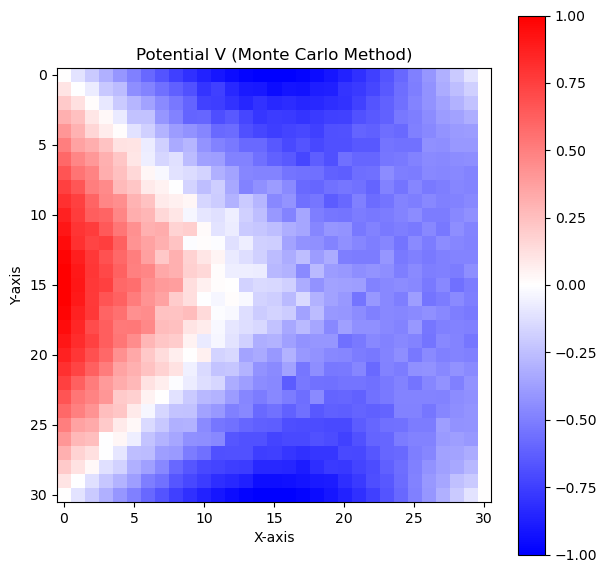

In [7]:
plt.figure(figsize = (7,7))
plt.imshow(V_mc.T, cmap='bwr')
plt.colorbar()
plt.title('Potential V (Monte Carlo Method)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

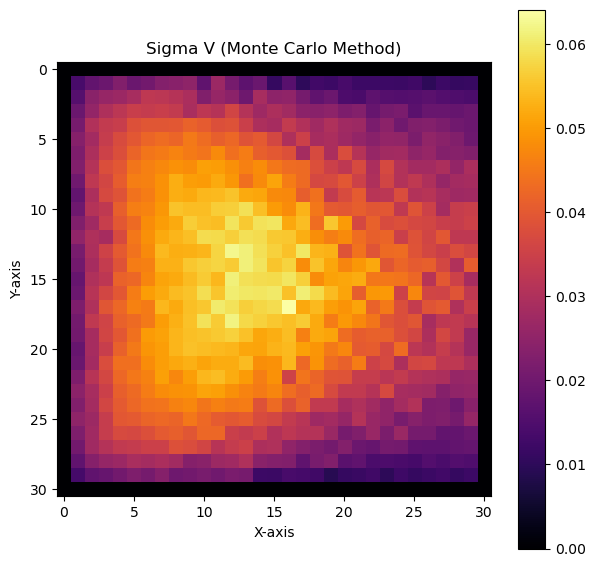

In [8]:
plt.figure(figsize = (7,7))
plt.imshow(sigma_V_mc.T, cmap='inferno')
plt.colorbar()
plt.title('Sigma V (Monte Carlo Method)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

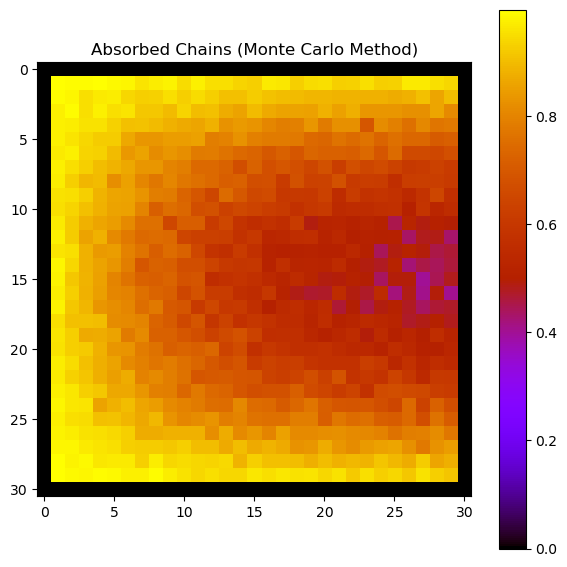

<Figure size 700x700 with 0 Axes>

In [9]:
plt.figure(figsize = (7,7))
plt.imshow(S_mc.T, cmap='gnuplot')
plt.colorbar()
plt.title('Absorbed Chains (Monte Carlo Method)')
plt.figure(figsize = (7,7))
plt.show()

## Porównanie wyników

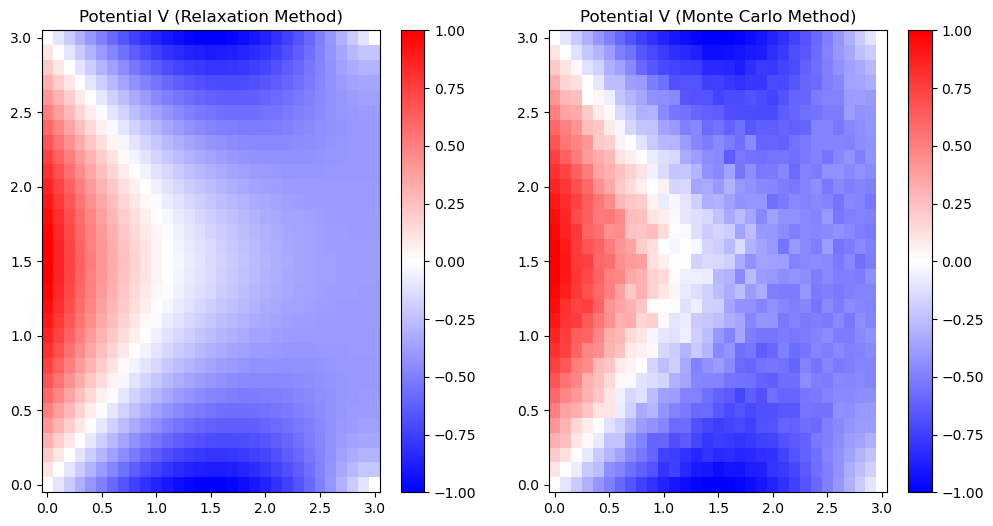

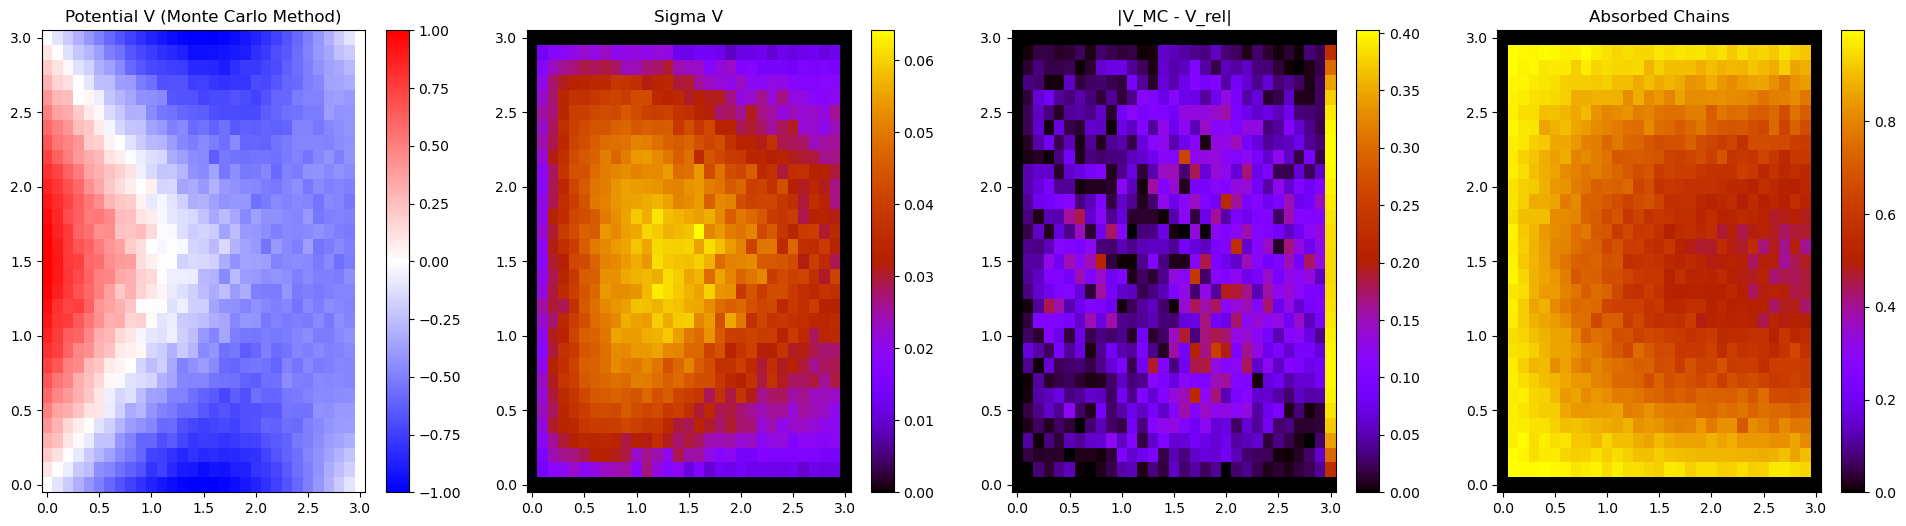

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

X, Y = np.meshgrid(np.linspace(0, nx * delta, nx + 1), np.linspace(0, ny * delta, ny + 1))

im1 = ax1.pcolormesh(X, Y, V_relaxed.T, cmap='bwr')
ax1.set_title('Potential V (Relaxation Method)')
fig.colorbar(im1, ax=ax1)

im2 = ax2.pcolormesh(X, Y, V_mc.T, cmap='bwr')
ax2.set_title('Potential V (Monte Carlo Method)')
fig.colorbar(im2, ax=ax2)

plt.show()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))

im1 = ax1.pcolormesh(X, Y, V_mc.T, cmap='bwr')
ax1.set_title('Potential V (Monte Carlo Method)')
fig.colorbar(im1, ax=ax1)

im2 = ax2.pcolormesh(X, Y, sigma_V_mc.T, cmap='gnuplot')
ax2.set_title(r'Sigma V')
fig.colorbar(im2, ax=ax2)

im3 = ax3.pcolormesh(X, Y, np.absolute(V_mc - V_relaxed).T, cmap='gnuplot')
ax3.set_title(r'|V_MC - V_rel|')
fig.colorbar(im3, ax=ax3)

im4 = ax4.pcolormesh(X, Y, S_mc.T, cmap='gnuplot')
ax4.set_title('Absorbed Chains')
fig.colorbar(im4, ax=ax4)

plt.show()